Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-conv-var.ipynb)

In [3]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Ewert&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Ewert; color:#ff6633;'>
    %s</h1>"""%str))

In [4]:
dhtml('Code Modules, Functions, & Classes')

In [5]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [6]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [7]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader
    if n=='2': data_loader=train_loader2
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

In [8]:
dhtml('Data')

In [9]:
random_seed=12; batch_size=128; img_size=28
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train=tmnist(root='data',train=True,
             download=True,transform=trans)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])




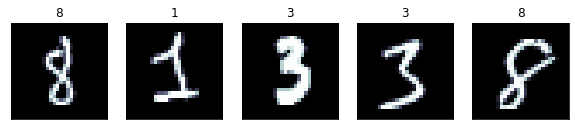

In [ ]:
%display_examples 1

In [ ]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=y.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_train=x[:n],x[n:]
y_test,y_train=y[:n],y[n:]
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


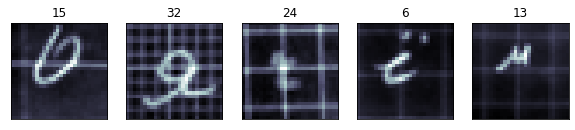

In [ ]:
%display_examples 2

In [11]:
dhtml('Convolutional Variational <br/>Autoencoder')

In [ ]:
class ConvVarAE(tnn.Module):
    def __init__(self,num_features,num_latent):
        super(ConvVarAE,self).__init__()
        # encoder
        self.conv_en1=tnn\
        .Conv2d(in_channels=1,out_channels=16,
                kernel_size=(6,6),stride=(2,2),
                padding=0)
        self.conv_en2=tnn\
        .Conv2d(in_channels=16,out_channels=32,
                kernel_size=(4,4),stride=(2,2),
                padding=0)                        
        self.conv_en3=tnn\
        .Conv2d(in_channels=32,out_channels=64,
                kernel_size=(2,2),stride=(2,2),
                padding=0)                           
        self.z_mean=tnn.Linear(64*2*2,num_latent)
        self.z_log_var=tnn.Linear(64*2*2,num_latent)
        # decoder
        self.linear_de1=tnn.Linear(num_latent,64*2*2)             
        self.deconv_de1=tnn\
        .ConvTranspose2d(in_channels=64,out_channels=32,
                         kernel_size=(2,2),stride=(2,2),
                         padding=0)                         
        self.deconv_de2=tnn\
        .ConvTranspose2d(in_channels=32,out_channels=16,
                         kernel_size=(4,4),stride=(3,3),
                         padding=1)       
        self.deconv_de3=tnn\
        .ConvTranspose2d(in_channels=16,out_channels=1,
                         kernel_size=(6,6),stride=(3,3),
                         padding=4)
    def reparameterize(self,z_mu,z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)       
    def encoder(self,features):
        x=self.conv_en1(features); x=tnnf.leaky_relu(x)       
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)      
        z_mean=self.z_mean(x.view(-1,64*2*2))
        z_log_var=self.z_log_var(x.view(-1,64*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)  
        return z_mean,z_log_var,encoded  
    def decoder(self,encoded):
        x=self.linear_de1(encoded)
        x=x.view(-1,64,2,2)     
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)       
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features):
        z_mean,z_log_var,encoded=self.encoder(features)
        decoded=self.decoder(encoded)
        return z_mean,z_log_var,encoded,decoded

In [ ]:
dhtml('Training')

In [ ]:
torch.manual_seed(random_seed)
learning_rate=.003; num_latent=15
model=ConvVarAE(num_features=img_size**2,
                num_latent=num_latent)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [ ]:
epochs=20
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):
        features=features.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features)
        kl_divergence=(.5*(z_mean**2+torch.exp(z_log_var)-
                           z_log_var-1)).sum()
        pixelwise_bce=tnnf\
        .binary_cross_entropy(decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train_loader),cost))

Epoch: 001/020 | Batch: 000/469 | Cost: 69506.0156
Epoch: 001/020 | Batch: 100/469 | Cost: 27884.4316
Epoch: 001/020 | Batch: 200/469 | Cost: 25599.5645
Epoch: 001/020 | Batch: 300/469 | Cost: 23761.5195
Epoch: 001/020 | Batch: 400/469 | Cost: 23680.5332
Epoch: 002/020 | Batch: 000/469 | Cost: 22764.9277
Epoch: 002/020 | Batch: 100/469 | Cost: 22025.4648
Epoch: 002/020 | Batch: 200/469 | Cost: 21878.7520
Epoch: 002/020 | Batch: 300/469 | Cost: 21061.3867
Epoch: 002/020 | Batch: 400/469 | Cost: 20503.7637
Epoch: 003/020 | Batch: 000/469 | Cost: 19473.9375
Epoch: 003/020 | Batch: 100/469 | Cost: 19229.2344
Epoch: 003/020 | Batch: 200/469 | Cost: 19110.0664
Epoch: 003/020 | Batch: 300/469 | Cost: 18370.1777
Epoch: 003/020 | Batch: 400/469 | Cost: 18368.9883
Epoch: 004/020 | Batch: 000/469 | Cost: 18231.3965
Epoch: 004/020 | Batch: 100/469 | Cost: 18458.2832
Epoch: 004/020 | Batch: 200/469 | Cost: 17296.5156
Epoch: 004/020 | Batch: 300/469 | Cost: 17392.7559
Epoch: 004/020 | Batch: 400/469

In [ ]:
dhtml('Reconstruction')

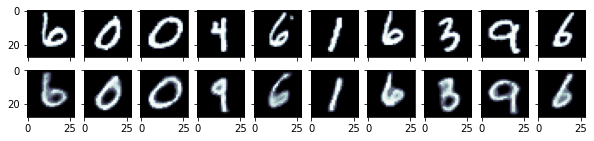

In [ ]:
num_images=10
fig,axes=pl.subplots(nrows=2,ncols=num_images, 
                     sharex=True,sharey=True,
                     figsize=(10,2))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,
                            decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')

In [ ]:
dhtml('Generating')

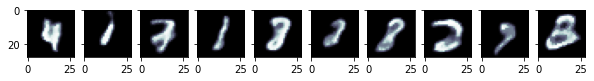

In [ ]:
num_images=10
latent_features=\
torch.randn(num_images,num_latent).to(dev)
generated_images=model.decoder(latent_features)
decoded_images=generated_images[:num_images]
fig,axes=pl.subplots(nrows=1,ncols=num_images,
                     figsize=(10,2),sharey=True)
for ax,img in zip(axes,decoded_images):
    ax.imshow(img.detach().to(torch.device('cpu'))\
              .reshape((img_size,img_size)),cmap='bone')

In [ ]:
dhtml('Convolutional Conditional <br/>Variational Autoencoder')

In [ ]:
ch1,ch2,ch3=16,48,144
def to_onehot(labels,num_classes,device):
    labels_ohe=torch.zeros(labels.size()[0],
                           num_classes).to(device)
    labels_ohe.scatter_(1,labels.view(-1,1),1)
    return labels_ohe
class CondVarAE(tnn.Module):
    def __init__(self,num_features,num_latent,num_classes):
        super(CondVarAE,self).__init__()
        self.num_classes=num_classes
        # ENCODER
        self.conv_en1=tnn\
        .Conv2d(in_channels=1+self.num_classes,
                out_channels=ch1,kernel_size=(6,6),
                stride=(2,2),padding=0)
        self.conv_en2=tnn\
        .Conv2d(in_channels=ch1,out_channels=ch2,
                kernel_size=(4,4),stride=(2,2),
                padding=0)                        
        self.conv_en3=tnn\
        .Conv2d(in_channels=ch2,out_channels=ch3,
                kernel_size=(2,2),stride=(2,2),
                padding=0)                     
        self.z_mean=tnn.Linear(ch3*2*2,num_latent)
        self.z_log_var=tnn.Linear(ch3*2*2,num_latent)
        # DECODER
        self.linear_de1=tnn\
        .Linear(num_latent+self.num_classes,ch3*2*2)
        self.deconv_de1=tnn\
        .ConvTranspose2d(in_channels=ch3,out_channels=ch2,
                         kernel_size=(2,2),stride=(2,2),
                         padding=0)                              
        self.deconv_de2=tnn\
        .ConvTranspose2d(in_channels=ch2,out_channels=ch1,
                         kernel_size=(4,4),stride=(3,3),
                         padding=1)
        
        self.deconv_de3=tnn\
        .ConvTranspose2d(in_channels=ch1,out_channels=1,
                         kernel_size=(6,6),stride=(3,3),
                         padding=4)        
    def reparameterize(self, z_mu, z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)    
    def encoder(self,features,targets):
        onehot_targets=\
        to_onehot(targets,self.num_classes,dev)
        onehot_targets=\
        onehot_targets.view(-1,self.num_classes,1,1)        
        ones=torch.ones(features.size()[0], self.num_classes,
                        features.size()[2],features.size()[3], 
                        dtype=features.dtype).to(dev)
        ones=ones*onehot_targets
        x=torch.cat((features,ones),dim=1)        
        x=self.conv_en1(x); x=tnnf.leaky_relu(x)      
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)     
        z_mean=self.z_mean(x.view(-1,ch3*2*2))
        z_log_var=self.z_log_var(x.view(-1,ch3*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)
        return z_mean,z_log_var,encoded  
    def decoder(self,encoded,targets):
        onehot_targets=\
        to_onehot(targets,self.num_classes,dev)
        encoded=torch.cat((encoded,onehot_targets),dim=1)        
        x=self.linear_de1(encoded)
        x=x.view(-1,ch3,2,2)  
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features,targets):      
        z_mean,z_log_var,encoded=self.encoder(features,targets)
        decoded=self.decoder(encoded,targets)     
        return z_mean,z_log_var,encoded,decoded

In [ ]:
dhtml('Training 2')

In [ ]:
torch.manual_seed(random_seed)
learning_rate=.0015; num_latent=121; num_classes=33
model=CondVarAE(num_features=img_size**2,
                num_latent=num_latent,
                num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [ ]:
epochs=200
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader2):
        features=features.to(dev)
        targets=targets.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features,targets.long())
        kl_divergence=(.5*(z_mean**2+torch.exp(z_log_var)-
                           z_log_var-1)).sum()
        pixelwise_bce=tnnf\
        .binary_cross_entropy(decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%50:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train_loader2),cost))

Epoch: 001/200 | Batch: 000/089 | Cost: 70784.0859
Epoch: 001/200 | Batch: 050/089 | Cost: 69400.5625
Epoch: 002/200 | Batch: 000/089 | Cost: 65585.0938
Epoch: 002/200 | Batch: 050/089 | Cost: 65769.6562
Epoch: 003/200 | Batch: 000/089 | Cost: 66263.1250
Epoch: 003/200 | Batch: 050/089 | Cost: 66170.2578
Epoch: 004/200 | Batch: 000/089 | Cost: 66222.2188
Epoch: 004/200 | Batch: 050/089 | Cost: 65488.8203
Epoch: 005/200 | Batch: 000/089 | Cost: 65078.8359
Epoch: 005/200 | Batch: 050/089 | Cost: 65211.5430
Epoch: 006/200 | Batch: 000/089 | Cost: 64591.1328
Epoch: 006/200 | Batch: 050/089 | Cost: 65833.0000
Epoch: 007/200 | Batch: 000/089 | Cost: 64859.6875
Epoch: 007/200 | Batch: 050/089 | Cost: 64751.0859
Epoch: 008/200 | Batch: 000/089 | Cost: 65580.0156
Epoch: 008/200 | Batch: 050/089 | Cost: 64960.0898
Epoch: 009/200 | Batch: 000/089 | Cost: 64038.9375
Epoch: 009/200 | Batch: 050/089 | Cost: 64562.8477
Epoch: 010/200 | Batch: 000/089 | Cost: 64511.3398
Epoch: 010/200 | Batch: 050/089

In [ ]:
dhtml('Reconstruction 2')

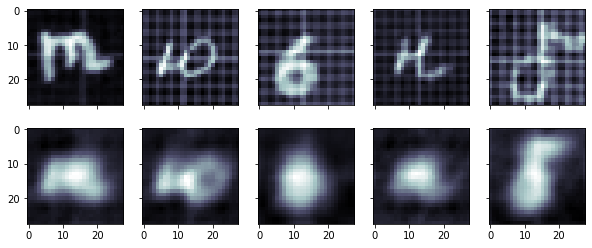

In [ ]:
num_images=5
fig,axes=pl.subplots(nrows=2,ncols=num_images, 
                     sharex=True,sharey=True,
                     figsize=(10,4))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,
                            decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')

In [ ]:
dhtml('Generating 2')

In [ ]:
@register_line_magic
def display_gen(l):
    l=int(l); num_images=5
    labels=torch.tensor([l]*num_images).to(dev)
    latent_features=\
    torch.randn(num_images,num_latent).to(dev)
    generated_images=model.decoder(latent_features,labels)
    decoded_images=generated_images[:num_images]
    fig,axes=pl.subplots(nrows=1,ncols=num_images,
                         figsize=(10,2),sharey=True)
    for ax,img in zip(axes,decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu'))\
                  .reshape((img_size,img_size)),cmap='bone') 

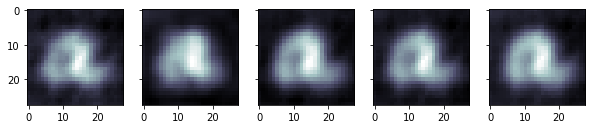

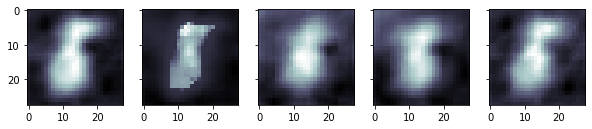

In [ ]:
%display_gen 0
%display_gen 1